## INF367: Final Project
# Fine-Tuning CodeBERT for Git Commit Message Generation
---
> by **Sebastian Einar Salas Røkholt**<br>
> INF367 - Selected Topics for Artificial Intelligence: Language Processing <br>
> Autumn 2022 <br>
> The University of Bergen, Department for Informatics <br>

---

Project code repository available at [Github.com](https://github.com/SebastianRokholt/CodeBERT-CommitMessage-Generator)
<br>

**[Read the Project Report](#)**
</br>

### Table of Contents

1. [**Introduction**](#intro)<br>

2. [**Inital Setup**](#setup)<br>

3. [**Data Collection**](#collection)<br>

4. [**Data Pre-processing**](#pre-processing)<br>

5. [**Modelling**](#modelling)<br>
    5.1       [*Architecture*](#architecture) <br>
    5.2       [*Fine-tuning CodeBERT on Git diffs*](#fine-tune) <br>
    5.3       [*Running predictions*](#pred) <br>

6. [**Evaluation and Future Work**](#test-eval) <br>

7. [**Credits and References**](#ref) <br>

---

### <a id="intro"></a>1) Introduction

The aim of this project is to extend the work on NL-PL language modelling proposed in [CodeBERT: A Pre-Trained Model for Programming and Natural Languages](https://arxiv.org/abs/2002.08155) (Feng et al, 2020) by reproducing and experimenting with the work proposed in [CommitBERT: Commit Message Generation Using Pre-Trained Programming Language Model](https://arxiv.org/abs/2105.14242) (Jung, 2021). 

The former of the two papers presented research on creating a large, pre-trained language model for natural language and programming language, with many possible downstream tasks such as code search, code repair, code completion, and code documentation generation. The latter of the two papers presents experiments on applying CodeBERT to code documentation generation, specifically an application for automatically generating commit messages. 

I will be attempting to experiment with the methodology proposed in the CommitBERT paper, and will hopefully be able to reproduce some of the results. It is important to note, however, that I have access to severely limited compute resources and will therefore not be able to reproduce a high-performance model. 

My primary goal with this project is to learn as much as I can about the methods proposed in the two papers. I want to achieve this goal by attempting to fine-tune a "CommitBERT"-style language model on a small dataset consisting of open source code repositories, including some of my own Github repositories. I hope that the resulting model will be able to capture some of my commit message writing style, though I obviously will need to fine-tune on many other repositories as well. 

Since I have resource and time constraint, I will not be doing all of the work from scratch. Specificaly, I will be downloading fine-tuned CodeBERT model weights to use as initial model weights before fine-tuning my own CodeBERT model on git diffs. The initial weights are retrieved from Tae-Hwan Jung's open source code for the CommitBERT paper. I will also be using a wide array of imported packages and tools, including Microsoft's CodeBERT training script from the original CodeBERT paper's code - though I have tweaked it somewhat in order to fit my machine learning pipeline. I have tried to give credit where credit is due, so that it is clear what code I have written myself and what I have imported from other libraries and projects. 

### Notebook Setup
This notebook is designed to run in Google Colab. Fine-tuning the language model on a CPU is infeasible, so you may either skip these cells (and download the trained weights) or attempt to fine-tune the model with a GPU/TPU. I trained on an Nvidia A100 Tensor Core GPU, which was available through Google Colab Pro.

In [1]:
%%sh
git clone https://github.com/SebastianRokholt/CodeBERT-CommitMessage-Generator.git
cd codebert-commit-generator
pip install -q -r requirements.txt

In [2]:
# Displaying the GPU setup for the notebook environment
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Nov  6 10:13:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   28C    P0    44W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# If training on an A100 GPU, the Pytorch installation needs to be Cu111 compatible
%%shell
pip install -q torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

In [2]:
# Utility stuff
import os
import easydict 
import whatthepatch
from tqdm import tqdm

# Visualizations
import matplotlib.pyplot as plt

# Deep learning stuff
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler
from transformers import (RobertaConfig, RobertaTokenizer)
from greykode_commit.model import Seq2Seq
from greykode_commit.utils import convert_examples_to_features
from greykode_commit.model.diff_roberta import RobertaModel

# Constants
MODEL_CLASSES = {'roberta': (RobertaConfig, RobertaModel, RobertaTokenizer)}

2022-11-06 17:31:27.720884: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-06 17:31:27.822276: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-06 17:31:27.822291: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-06 17:31:27.843269: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-06 17:31:28.352815: W tensorflow/stream_executor/platform/de

### Data Collection and Wrangling

Scraping Github Repositories. 
I will try to collect git diffs from 50 repositories, where 4 of them are my own. 

In [3]:
from queue import Queue
import git
from time import sleep
import os
from threading import Thread

class RepoScraper():
    """
    A class for "Scraping" Git Repositories, i.e. downloading by git cloning them to the specified download path.
    """
    def __init__(self, repositories, download_path):
        """
        :param repositories: The total number of Github repositories to be downloaded
        :param download_path: The path to the directory for downloading all of the scraped repositories
        """
        self.queue = Queue()  # data structure for scraping repos
        self.count = 0  # keeps track of progress
        self.total_n_repos = len(repositories)
        self.download_path = download_path

        # Multithreading with 16 threads.
        # NB! More threads => higher memory usage
        for _ in range(16):
            _thread = Thread(target=self.cloner)
            _thread.daemon = True
            _thread.start()

    def clone_repos(self, repo_gh_file_path):
        """
        :param repo_gh_file_path: The file path to the Github repository, e.g: SebastianRokholt/CodeBERT-CommitMessage-Generator
        """
        try:
            # Clone repo to download dir
            git.Repo.clone_from(
                f'https://:@github.com/{repo_gh_file_path}.git',
                f'{self.download_path}/{repo_gh_file_path}'
            )

            sleep(0.2)  # Trying to avoid blacklisting due to high page request frequency

            self.count += 1 
            print(f"Progress: {self.count} out of {self.total_n_repos} downloaded. ")
        
        # Very basic error handling
        except git.exc.GitError as e:
            print(f"The following error occurred while attempting to clone repository from https://:@github.com/{repo_gh_file_path}.git: ")
            print(e)

    def cloner(self):
        """
        Runs the crawling method (clone_repos) on the repositories according to the crawl queue. 
        Called by the multithreading daemon. 
        Terminates when the crawl queue is empty. 
        """
        while True:
            repo_file_path = self.queue.get()  # Retrieves the next repo from the queue
            self.clone_repos(repo_file_path)  # Runs the crawling method on the repo
            self.queue.task_done()  # Registers the task (crawling the repo) as completed

    def join_queue(self):
        """
        Blocks until all repos in the crawl queue have been gotten and processed.
        Unblocks when count of unfinished tasks drops to zero.
        """
        self.queue.join()

    def put_queue(self, repo_file_path):
        """
        Puts a repo into the crawl queue. 
        """
        self.queue.put(repo_file_path)
        

download_path="data/raw/python"
os.makedirs(download_path, exist_ok=True)

# Read the repositories to crawl from file
repositories = []
with open("repositories/python-50.txt", encoding="utf-8") as file:
    for line in file:
        line = line.strip()
        repositories.append(line.replace('https://github.com/', ''))
print("Repositories to crawl:", repositories)

# Instantiate the repo scraper
scraper = RepoScraper(repositories=set(repositories), download_path=download_path)

# Start scraping
for repo in repositories:
    # Put each repo in the crawl queue
    scraper.put_queue(repo)
scraper.join_queue()

Repositories to crawl: ['SebastianRokholt/Data-Science-Projects', 'SebastianRokholt/Hybrid-Recommender-System', 'Jonnashell/info216-groupproject', 'SebastianRokholt/Soccer-Predictions', 'IBM/pytorch-seq2seq', 'tiangolo/fastapi', 'TheAlgorithms/Python', 'vinta/awesome-python', 'django/django', 'pallets/flask', 'httpie/httpie', 'josephmisiti/awesome-machine-learning', 'ansible/ansible', 'psf/requests', 'deepfakes/faceswap', 'apache/incubator-superset', 'XX-net/XX-Net', 'pandas-dev/pandas', 'satwikkansal/wtfpython', 'pypa/pipenv', 'donnemartin/interactive-coding-challenges', 'mitmproxy/mitmproxy', 'donnemartin/data-science-ipython-notebooks', 'tornadoweb/tornado', 'chubin/cheat.sh', 'trailofbits/algo', 'geekcomputers/Python', 'encode/django-rest-framework', 'apache/airflow', 'matterport/Mask_RCNN', 'swisskyrepo/PayloadsAllTheThings', 'yunjey/pytorch-tutorial', 'sqlmapproject/sqlmap', 'psf/black', 'keon/algorithms', 'google/python-fire', 'explosion/spaCy', 'drduh/macOS-Security-and-Privacy

In [ ]:
# Here I used Tae-Hwang Jung's pre-processing algorithm (CommitBERT paper page 4) 
# and parsing script (gitparser.py) as a starting point and guide:
# https://github.com/graykode/commit-autosuggestions/blob/master/gitparser.py
# See the project report for details about which changes I made, and why. 

# IMPORTS
import os
import re
import json
import random
import jsonlines
import spacy
import errno
from pydriller import RepositoryMining
from transformers import RobertaTokenizer
from nltk.tokenize import word_tokenize
from spacy.language import Language
from spacy_langdetect import LanguageDetector

# CONSTANTS
repositories="repositories/python-50.txt"
repos_dir="data/raw/python"
output_dir="data/parsed/python"
output_file = os.path.join(output_dir, 'dataset.jsonl')
cb_tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")

# LANGUAGE DETECTION
@Language.factory("language_detector")
def create_language_detector(nlp, name):
    return LanguageDetector(language_detection_function=None)

detect_lang = spacy.load("en_core_web_sm")
detect_lang.add_pipe('language_detector')
english_not_detected = []


# GENERAL FUNCTIONS
def process_commits(repos_dir, repo, codebert_tokenize="code_only"):
    """
    Pre-processes commit messages in a repo.
    Tokenizes the commit messages and the diff code for each commit in a repository. 
    Determines whether diff code has been added or deleted.

    :param repo: A pre-downloaded Git repository to process.
    :param codebert_tokenize: Specifies whether to tokenize the message text and/or code in the commit message. 
                     Set to "all" (default), "code_only" or None. 
    """
    repo_path = os.path.join(repos_dir, repo)
    # Basic error handling for input params
    if codebert_tokenize not in ["code_only", "all", None]:
        raise Exception("Input parameter codebert_tokenize must be 'code_only', 'all' or None. ")
    if not os.path.exists(repo_path):
        raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), repo_path)

    # Loops over all commits in the repository (Python code only)
    for commit in RepositoryMining(repo_path, only_modifications_with_file_types="py").traverse_commits():
        # Get the commit message text
        msg = commit.msg.split("\n")[0]
        # Remove unecessary characters from the message
        cleaned_msg = re.sub(r"(\(|)#([0-9])+(\)|)", "", msg)
        # Only keep commits with commit messages in English
        langdetect_result = detect_lang(cleaned_msg)._.language
        if langdetect_result["language"] != "en":
            english_not_detected.append(cleaned_msg)
            continue
        # Tokenizing the commit message text
        if codebert_tokenize == "all":
            # Tokenize the commit message with a CodeBERT tokenizer
            msg_tokens = cb_tokenizer.tokenize(cleaned_msg)
        else: 
            # Only perform simple NLTK tokenization
            msg_tokens = word_tokenize(cleaned_msg)

        # Only keep messages that are over a certain length, so that the model has enough text to train on
        if len(msg_tokens) < 3:
            continue
        # Only keep commits with less than four file changes
        if len(commit.modifications) > 3:
            continue
        # Discard commits that reference an issue, e.g. "#454123" or "gh-24558"
        filter_expr = re.compile(r'(#|gh-)[0-9]{3,}')
        if any((match := filter_expr.search(msg_token)) for msg_token in msg_tokens):
            print(f"Discarding commit, found issue reference in:\n{msg_token}")
            continue
        
        # Looping over the file modifications in the commit
        for mod in commit.modifications:
            # FILTERING
            if not (mod.old_path and mod.new_path):
                continue
            if os.path.splitext(mod.new_path)[1] != ".py": # Python code only (excluding notebooks)
                continue
            if (not mod.diff_parsed["added"]) or (not mod.diff_parsed["deleted"]): # Only added and deleted code
                continue
            
            # Keep track of added and deleted code in the file
            added, deleted = [], []

            # Looping over added lines of code
            for _, code in mod.diff_parsed["added"]:
                if codebert_tokenize == "all" or codebert_tokenize == "code_only":
                    # Tokenizing the added line of code with a CodeBERT tokenizer
                    code = cb_tokenizer.tokenize(code)
                added.extend(code)

            # Looping over deleted lines of code
            for _, code in mod.diff_parsed["deleted"]:
                if codebert_tokenize == "all" or codebert_tokenize == "code_only":
                    # Tokenizing the deleted line of code with a CodeBERT tokenizer
                    code = cb_tokenizer.tokenize(code)
                deleted.extend(code)
            
            # Check to see if the source length is a max of 256 tokens. 
            # (Long messages make fine-tuning difficult)
            if added and deleted and (len(added) + len(deleted) <= 256):
                with jsonlines.open(output_file, mode="a") as writer:
                    writer.write({
                            "commit_message": msg_tokens,
                            "added": added,
                            "deleted": deleted
                            })

# Saves parsed (tokenized) code to json lines (.jsonl)
def create_jsonl_dataset(lines, purpose):
    saved_path = os.path.join(output_dir, purpose)
    for line in lines:
        with jsonlines.open(f"{saved_path}.jsonl", mode="a") as dataset:
            dataset.write(line)


# RUNNING THE PRE-PROCESSING STEPS ON THE DOWNLOADED REPOSITORIES
repos = set()
with open(repositories, encoding="utf-8") as f:
    for _, line in enumerate(f):
        line = line.strip()
        repos.add(line.replace('https://github.com/', ''))

# Ensure that the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Process the Git repositories
for i, repo in enumerate(repos): 
    print(f"Processing repo number {i + 1} out of {len(repos)} ({repo})")
    try:
        process_commits(repos_dir, repo, codebert_tokenize="code_only")
    except FileNotFoundError as err:
        print(err)
        continue

# Printing some negative samples from language detection task
print(f"Some examples of words that were labelled as not English: ", english_not_detected[:30])
print(f"Number of words labelled as not English: {len(english_not_detected)}\n\n")

# Load the processed commits from the dataset.jsonl file to a single list
data = []
with open(output_file, encoding="utf-8") as dataset_file:
    for line in dataset_file:
        line = line.strip()  # Remove unecessary whitespace
        data.append(json.loads(line))

# Creating train, validation and test datasets by shuffling and splicing the list
# Adding a seed to the randomizer keeps the split consistent over multiple trials
random.seed(42)
random.shuffle(data)
create_jsonl_dataset(data[:int(len(data) * 0.9)], purpose='train')
create_jsonl_dataset(data[int(len(data) * 0.9):int(len(data) * 0.95)], purpose='valid')
create_jsonl_dataset(data[int(len(data) * 0.95):], purpose='test')

print("\nShowing some examples of training data: ")
for data_dict in data[:int(len(data) * 0.9)][:10]:
    print(data_dict)

### Fine-Tuning CodeBERT on Git Diffs

In [ ]:
%%shell
cd CodeBERT-CommitMessage-Generator
python3 train.py --help

usage: train.py [-h] --model_type MODEL_TYPE --model_name_or_path
                MODEL_NAME_OR_PATH --output_dir OUTPUT_DIR
                [--load_model_path LOAD_MODEL_PATH]
                [--train_filename TRAIN_FILENAME]
                [--dev_filename DEV_FILENAME] [--test_filename TEST_FILENAME]
                [--config_name CONFIG_NAME] [--tokenizer_name TOKENIZER_NAME]
                [--max_source_length MAX_SOURCE_LENGTH]
                [--max_target_length MAX_TARGET_LENGTH] [--do_train]
                [--do_eval] [--do_test] [--do_lower_case] [--no_cuda]
                [--train_batch_size TRAIN_BATCH_SIZE]
                [--eval_batch_size EVAL_BATCH_SIZE]
                [--gradient_accumulation_steps GRADIENT_ACCUMULATION_STEPS]
                [--learning_rate LEARNING_RATE] [--beam_size BEAM_SIZE]
                [--weight_decay WEIGHT_DECAY] [--adam_epsilon ADAM_EPSILON]
                [--max_grad_norm MAX_GRAD_NORM]
                [--num_train_epochs NUM_TRAI

In [ ]:
PRETRAINED_CODEBERT_MODEL='1YrkwfM-0VBCJaa9NYaXUQPODdGPsmQY4'
!pip install gdown \
    && mkdir -p CodeBERT-CommitMessage-Generator/models/added \
    && gdown "https://drive.google.com/uc?id=$PRETRAINED_CODEBERT_MODEL" -O models/added/pytorch_model.bin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Downloading...
From: https://drive.google.com/uc?id=1YrkwfM-0VBCJaa9NYaXUQPODdGPsmQY4
To: /content/models/added/pytorch_model.bin
100% 707M/707M [00:02<00:00, 261MB/s]


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Nov  6 02:18:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    64W / 400W |      0MiB / 40536MiB |      4%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Using Microsoft's CodeBERT training script (with Tae-Hwang Jung's modifications) 
# to fine-tune CodeBERT on Git repositories
%%shell

lr=5e-5
batch_size=32
beam_size=8  # Reduced from 10
source_length=256  # Maximum code input token length
target_length=128  # Maximum commit message text token length
output_dir=models/diff
train_file=data/parsed/python/train.jsonl  # 80%
dev_file=data/parsed/python/valid.jsonl  # 10%
test_file=data/parsed/python/test.jsonl  # 10%
num_train_epochs=8  # Number of training epochs to perform
eval_steps=1000  # Number of evaluation steps to perform
# The encoder of the Seq2Seq transformer model 
# is initialised with CodeBERT weights fine-tuned for code documentation generation
saved_model=models/added/pytorch_model.bin

python3 train.py --do_train --do_eval --do_test --model_type roberta \
	--model_name_or_path microsoft/codebert-base \
	--load_model_path $saved_model \
	--train_filename $train_file \
	--dev_filename $dev_file \
	--test_filename $test_file \
	--output_dir $output_dir \
	--max_source_length $source_length \
	--max_target_length $target_length \
	--beam_size $beam_size \
	--train_batch_size $batch_size \
	--eval_batch_size $batch_size \
	--learning_rate $lr \
	--train_steps $train_steps \
	--eval_steps $eval_steps

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
  0% 0/10000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:764: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  "The `device` argument is deprecated and will be removed in v5 of Transformers.", FutureWarning
loss 0.6633:  10% 998/10000 [15:41<2:22:30,  1.05it/s]/content/CodeBERT-CommitMessage-Generator/commit/model/model.py:169: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a

In [ ]:
from google.colab import files
files.download("CodeBERT-CommitMessage-Generator/models/diff/checkpoint-best-bleu/pytorch_model.bin")

Total train steps:  10000
Total eval steps:  10


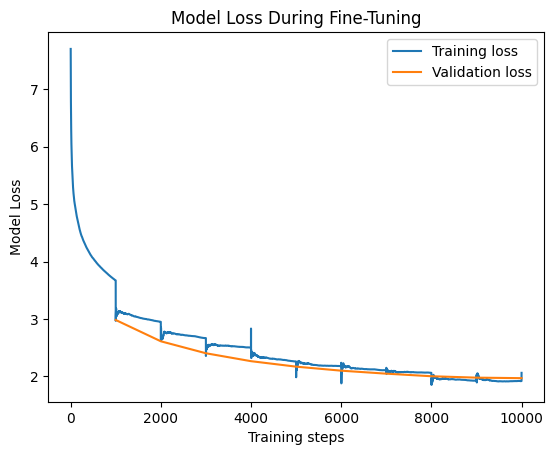

In [5]:
# Visualizing training loss
train_loss = []
eval_loss = []
with open("models/diff/loss/train_loss-python-50.txt", "r", encoding="UTF-8") as file:
    for line in file.readlines():
        step, loss = line.split(":")
        train_loss.append(float(loss.replace("\n", "")))

with open("models/diff/loss/eval_loss-python-50.txt", "r", encoding="UTF-8") as file:
    for line in file.readlines():
        step, loss = line.split(":")
        eval_loss.append(float(loss.replace("\n", "")))
        
print(f"Total train steps: ", len(train_loss))
print(f"Total eval steps: ", len(eval_loss))
train_steps = [i for i in range(len(train_loss))]
eval_steps = [(i+1)*1000 for i in range(len(eval_loss))]
plt.plot(train_steps, train_loss, label="Training loss")
plt.plot(eval_steps, eval_loss, label="Validation loss")
plt.title('Model Loss During Fine-Tuning')
plt.xlabel('Training steps')
plt.ylabel('Model Loss')
plt.legend()
plt.show()

### Running predictions on a single example

In [6]:
!ls models/diff

loss		   pytorch_model_tuned_python-50.bin
pytorch_model.bin  pytorch_model_tuned_python-5.bin


In [7]:
class Example(object):
    """A single training/test example."""
    def __init__(self,
                 idx,
                 added,
                 deleted,
                 target,
                 ):
        self.idx = idx
        self.added = added
        self.deleted = deleted
        self.target = target

def get_model(model_class, config, tokenizer, mode):
    encoder = model_class(config=config)
    decoder_layer = nn.TransformerDecoderLayer(
        d_model=config.hidden_size, nhead=config.num_attention_heads
    )
    decoder = nn.TransformerDecoder(decoder_layer, num_layers=6)
    model = Seq2Seq(encoder=encoder, decoder=decoder, config=config,
            beam_size=args.beam_size, max_length=args.max_target_length,
            sos_id=tokenizer.cls_token_id, eos_id=tokenizer.sep_token_id)

    assert args.load_model_path
    print("model path: ", os.path.join(args.load_model_path, mode, 'pytorch_model.bin'))
    assert os.path.exists(os.path.join(args.load_model_path, mode, 'pytorch_model.bin'))

    model.load_state_dict(
        torch.load(
            os.path.join(args.load_model_path, mode, 'pytorch_model.bin'),
            map_location=torch.device('cpu')
        ),
        strict=False
    )
    return model

def get_features(examples):
    features = convert_examples_to_features(examples, args.tokenizer, args, stage='test')
    all_source_ids = torch.tensor(
        [f.source_ids[:args.max_source_length] for f in features], dtype=torch.long
    )
    all_source_mask = torch.tensor(
        [f.source_mask[:args.max_source_length] for f in features], dtype=torch.long
    )
    all_patch_ids = torch.tensor(
        [f.patch_ids[:args.max_source_length] for f in features], dtype=torch.long
    )
    return TensorDataset(all_source_ids, all_source_mask, all_patch_ids)

def inference(model, data):
    """
    :data: A torch.utils.data.dataset.TensorDataset object
    """
    # Calculate bleu
    eval_sampler = SequentialSampler(data)
    eval_dataloader = DataLoader(data, sampler=eval_sampler, batch_size=len(data))

    model.eval()
    p = []
    for batch in tqdm(eval_dataloader, total=len(eval_dataloader)):
        batch = tuple(t.to(args.device) for t in batch)
        source_ids, source_mask, patch_ids = batch
        with torch.no_grad():
            preds = model(source_ids=source_ids, source_mask=source_mask, patch_ids=patch_ids)
            for pred in preds:
                t = pred[0].cpu().numpy()
                t = list(t)
                if 0 in t:
                    t = t[:t.index(0)]
                text = args.tokenizer.decode(t, clean_up_tokenization_spaces=False)
                p.append(text)
    return p

args = easydict.EasyDict({
    'load_model_path': 'models', 
    'model_type': 'roberta',
    'config_name' : 'microsoft/codebert-base',
    'tokenizer_name' : 'microsoft/codebert-base',
    'max_source_length' : 512,
    'max_target_length' : 128,
    'beam_size' : 10,
    'do_lower_case' : False,
    'device' : torch.device("cuda" if torch.cuda.is_available() else "cpu")
})

print("Is GPU available?  ", torch.cuda.is_available())

Is GPU available?   False


Building the PL-NL model with the fine-tuned weights

In [8]:
config_class, model_class, tokenizer_class = MODEL_CLASSES[args.model_type]
config = config_class.from_pretrained(args.config_name)
args.tokenizer = tokenizer_class.from_pretrained(args.tokenizer_name, do_lower_case=args.do_lower_case)

# Build model
args.diff_model = get_model(model_class=model_class, config=config,
                        tokenizer=args.tokenizer, mode='diff').to(args.device)

model path:  models/diff/pytorch_model.bin


Running prediction

In [15]:
diffmessage = """
diff --git a/newfile.py b/newfile.py
new file mode 100644
index 0000000..cbb72b8
--- /dev/null
+++ b/newfile.py
@@ -0,0 +1,9 @@
+#!/usr/bin/env python3
+
-import torch
-import argparse
-import numpy
+import numpy as np
+def multiply_vectors(v1, v2):
+    return np.dot(v1, v2)
"""

diffmessage2 = """
diff --git a/test.py b/test.py
index d13f441..1b1b82a 100644
--- a/test.py
+++ b/test.py
@@ -1,6 +1,3 @@

-import torch
-import argparse
-import numpy
-import sklearn
+import matplotlib.pyplot as plt
def add(a, b):
     return a + b
"""

diffmessage3 = """
diff --git a/test.py b/test.py
new file mode 100644
index 0000000..d13f441
--- /dev/null
+++ b/test.py
@@ -0,0 +1,6 @@
+
+import torch
+import argparse
+
+def add(a, b):
+    return a + b
"""

diffmessage4 = """
diff --git a/newfile.py b/newfile.py
new file mode 100644
index 0000000..8724a42
--- /dev/null
+++ b/newfile.py
@@ -0,0 +1,5 @@
+#!usr/bin/env python3
+
+# Gets the url
+def get_url(domain, path):
+    return domain + "/" + path
diff --git a/ngrok.conf b/ngrok.conf
new file mode 100644
index 0000000..8e50d0f
--- /dev/null
"""

In [17]:
for i, diffmsg in enumerate([diffmessage, diffmessage2, diffmessage3, diffmessage4]):
    # Parse the git diff with whatthepatch package
    # Retrieve changes (added and deleted lines of code)
    for idx, example in enumerate(whatthepatch.parse_patch(diffmsg)):
        if not example.changes:
            print(f"no changes in {idx}")
            continue

        isadded, isdeleted = False, False
        added, deleted = [], []

        # Determine if the line is added or deleted and add it to the corresponding list
        for change in example.changes:
            if change.old == None and change.new != None and change.line != "":
                added.append(change.line)
                isadded = True
            elif change.old != None and change.new == None and change.line != "":
                deleted.append(change.line)
                isdeleted = True

        # Tokenization
        added_tokens = args.tokenizer.tokenize(" ".join(added))
        deleted_tokens = args.tokenizer.tokenize(" ".join(deleted))
        print(f"\n\n----- Tokenized diff, from diff number {i + 1} ------")
        print(added_tokens)
        print(deleted_tokens)

        # Create a numerical vector representation
        testsample = [Example(idx, added_tokens, deleted_tokens, target=None)]
        sampledata = get_features(testsample)

        # Generate a commit message
        message = inference(model=args.diff_model, data=sampledata)
        print("Autogenerated commit message: \n", message)



----- Tokenized diff number 0 ------
['#', '!/', 'usr', '/', 'bin', '/', 'env', 'Ġpython', '3', 'Ġimport', 'Ġn', 'umpy', 'Ġas', 'Ġnp', 'Ġdef', 'Ġmultiply', '_', 've', 'ctors', '(', 'v', '1', ',', 'Ġv', '2', '):', 'Ġ', 'Ġ', 'Ġ', 'Ġ', 'Ġreturn', 'Ġnp', '.', 'dot', '(', 'v', '1', ',', 'Ġv', '2', ')']
['import', 'Ġtorch', 'Ġimport', 'Ġarg', 'parse', 'Ġimport', 'Ġn', 'umpy']


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.36s/it]


Autogenerated commit message: 
 ['naming convention fixes in many files ']


----- Tokenized diff number 1 ------
['import', 'Ġmat', 'plot', 'lib', '.', 'py', 'plot', 'Ġas', 'Ġpl', 't']
['import', 'Ġtorch', 'Ġimport', 'Ġarg', 'parse', 'Ġimport', 'Ġn', 'umpy', 'Ġimport', 'Ġsk', 'learn']


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.18s/it]


Autogenerated commit message: 
 ['isort --profile black . ']


----- Tokenized diff number 2 ------
['import', 'Ġtorch', 'Ġimport', 'Ġarg', 'parse', 'Ġdef', 'Ġadd', '(', 'a', ',', 'Ġb', '):', 'Ġ', 'Ġ', 'Ġ', 'Ġ', 'Ġreturn', 'Ġa', 'Ġ+', 'Ġb']
[]


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.77s/it]


Autogenerated commit message: 
 ['naming convention fixes in many files ']


----- Tokenized diff number 3 ------
['#', '!', 'usr', '/', 'bin', '/', 'env', 'Ġpython', '3', 'Ġ#', 'ĠGets', 'Ġthe', 'Ġurl', 'Ġdef', 'Ġget', '_', 'url', '(', 'domain', ',', 'Ġpath', '):', 'Ġ', 'Ġ', 'Ġ', 'Ġ', 'Ġreturn', 'Ġdomain', 'Ġ+', 'Ġ"/', '"', 'Ġ+', 'Ġpath']
[]


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.13s/it]


Autogenerated commit message: 
 ['Update pythonfinder']


----- Tokenized diff number 3 ------
['auth', 'token', ':', 'Ġ1', 'ks', 'k', 'Z', 'g', 'J', '8', 'K', 'p', 'CR', 'v', 'Y', 'nz', 'SF', '63', 'Ac', 'od', 'v', 'Br', '_', '4', 'RM', 'X', 'x', 'F', 'o', '4', 'Sa', '2', 'q', 'L', 'r', 'Ra', 'K', 'j', 'h', 'J', 'W', 'Ġregion', ':', 'Ġj', 'p', 'Ġconsole', '_', 'ui', ':', 'ĠFalse', 'Ġtunnels', ':', 'Ġ', 'Ġ', 'Ġinput', ':', 'Ġ', 'Ġ', 'Ġ', 'Ġ', 'Ġaddr', ':', 'Ġ5000', 'Ġ', 'Ġ', 'Ġ', 'Ġ', 'Ġproto', ':', 'Ġhttp', 'Ġ', 'Ġ', 'Ġ', 'Ġ', 'Ġ', 'Ġ', 'Ġoutput', ':', 'Ġ', 'Ġ', 'Ġ', 'Ġ', 'Ġaddr', ':', 'Ġ5000', 'Ġ', 'Ġ', 'Ġ', 'Ġ', 'Ġproto', ':', 'Ġhttp']
[]


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.88s/it]

Autogenerated commit message: 
 ['Native YAML - system ']
